In [1]:
import argparse
import os
import re
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from typing import List, Tuple, Optional
from moviepy.editor import ImageSequenceClip
import subprocess

In [2]:
import sys
import os

# Add the folder to the path
sys.path.append(os.getcwd())

# Now import normally
import sam2

In [3]:
from sam2.build_sam import build_sam2_video_predictor

In [437]:
class SAM2LongProcessor:
    SAM_DIR = "/users/5/ribei056/software/python/sam2"
    SAM2LONG_DIR = "//users/5/ribei056/software/python/SAM2Long/sam2"
    def __init__(self):
        self.frame_rate_render = 6
        self.visualization_step = 15
        self.unique_id = None
        self.outdir = None
        self.start_frame = 0
        self.inference_state = None
        self.predictor = None
        self.first_frame_path = None
        self.tracking_points = []
        self.trackings_input_label = []
        self.video_frames_dir = None
        self.scanned_frames = []
        self.frame_names = []
        self.available_frames = []
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def load_model(self, checkpoint="tiny"):
        """Load the SAM2 model based on the specified checkpoint size"""
        if checkpoint == "tiny":
            sam2_checkpoint = f"{self.SAM_DIR}/checkpoints/sam2.1_hiera_tiny.pt"
            model_cfg = f"{self.SAM2LONG_DIR}/configs/sam2.1/sam2.1_hiera_t.yaml"
        elif checkpoint == "small":
            sam2_checkpoint = f"{self.SAM_DIR}/checkpoints/sam2.1_hiera_small.pt"
            model_cfg = f"{self.SAM2LONG_DIR}/configs/sam2.1/sam2.1_hiera_s.yaml"
        elif checkpoint == "base-plus":
            sam2_checkpoint = f"{self.SAM_DIR}/checkpoints/sam2.1_hiera_base_plus.pt"
            model_cfg = f"{self.SAM2LONG_DIR}/configs/sam2.1/sam2.1_hiera_b+.yaml"
        else:
            raise ValueError(f"Invalid checkpoint: {checkpoint}")

        print(f"Loading checkpoint: {checkpoint}, ({sam2_checkpoint}, {model_cfg})")
        self.predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=self.device)
        print("Model loaded successfully")
        return self.predictor

    def preprocess_video(self, video_path, outdir, max_duration=60):
        """
        Extract frames from a video file.
        Args:
            video_path: Path to the video file
            outdir: Output directory path
            max_duration: Maximum duration to process in seconds
        Returns:
            Path to the first frame
        """
        try:
            # Generate a unique ID based on the video filename
            self.unique_id = os.path.splitext(os.path.basename(video_path))[0]

            # Create output directory
            self.outdir = outdir
            extracted_frames_output_dir = f'{self.outdir}/frames_{self.unique_id}'

            # Create output directories if they don't exist
            os.makedirs(extracted_frames_output_dir, exist_ok=True)
            os.makedirs(f"{self.outdir}/frames_output_images", exist_ok=True)

            # Check if frames already exist
            existing_frames = [
                p for p in os.listdir(extracted_frames_output_dir)
                if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
            ]

            # If frames already exist, skip extraction
            if existing_frames:
                print(f"Found {len(existing_frames)} existing frames, skipping extraction")
                self.scanned_frames = existing_frames
                self.scanned_frames.sort(key=lambda p: int(os.path.splitext(p)[0]))
                self.video_frames_dir = extracted_frames_output_dir
                self.first_frame_path = os.path.join(extracted_frames_output_dir, self.scanned_frames[0])
                print(f"Using existing frames from: {extracted_frames_output_dir}")
                print(f"First frame at: {self.first_frame_path}")
                return self.first_frame_path

            # Open the video file
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise ValueError(f"Error: Could not open video file {video_path}")

            try:
                # Get video properties
                fps = cap.get(cv2.CAP_PROP_FPS)
                if fps <= 0:
                    print(f"Warning: Invalid FPS ({fps}), using default value of 30")
                    fps = 30

                max_frames = int(fps * max_duration)

                # Extract frames
                frame_number = 0
                while True:
                    ret, frame = cap.read()
                    if not ret or frame_number >= max_frames:
                        break

                    if frame_number % self.frame_rate_render == 0:  # Save every nth frame
                        frame_filename = os.path.join(extracted_frames_output_dir, f'{frame_number:05d}.jpg')
                        # Check if frame file already exists
                        if not os.path.exists(frame_filename):
                            cv2.imwrite(frame_filename, frame)

                    # Store first frame path
                    if frame_number == 0:
                        self.first_frame_path = os.path.join(extracted_frames_output_dir, f'{frame_number:05d}.jpg')

                    frame_number += 1

            except Exception as e:
                print(f"Error during frame extraction: {str(e)}")
                raise
            finally:
                # Release video resources
                cap.release()

            # Scan all JPEG frames
            self.scanned_frames = [
                p for p in os.listdir(extracted_frames_output_dir)
                if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
            ]

            if not self.scanned_frames:
                raise ValueError(f"No frames were extracted from the video {video_path}")

            self.scanned_frames.sort(key=lambda p: int(os.path.splitext(p)[0]))
            self.video_frames_dir = extracted_frames_output_dir

            print(f"Processed {len(self.scanned_frames)} frames from video")
            print(f"First frame saved at: {self.first_frame_path}")

            # Return the path to access the first frame
            return self.first_frame_path

        except FileNotFoundError:
            print(f"Error: Video file not found: {video_path}")
            raise
        except PermissionError:
            print(f"Error: Permission denied when accessing {video_path} or {outdir}")
            raise
        except Exception as e:
            print(f"Error processing video {video_path}: {str(e)}")
            raise

    def add_point(self, x, y, start_frame_idx, point_type="include"):
        """
        Add a tracking point
        """
        self.tracking_points.append([x, y])
        if start_frame_idx < 0:
            raise ValueError("Start frame index must be >= 0")
        self.start_frame = ((start_frame_idx + self.frame_rate_render - 1) // self.frame_rate_render) * self.frame_rate_render
        self.start_frame_idx = self.start_frame // self.frame_rate_render

        # Add label (1 for include, 0 for exclude)
        if point_type == "include":
            self.trackings_input_label.append(1)
        elif point_type == "exclude":
            self.trackings_input_label.append(0)
        else:
            raise ValueError("Point type must be 'include' or 'exclude'")

        print(f"Added {point_type} point at ({x}, {y}) starting at frame {self.start_frame}")
        return self.tracking_points, self.trackings_input_label

    def clear_points(self):
        """Clear all tracking points"""
        self.tracking_points = []
        self.trackings_input_label = []
        print("All points cleared")
        return self.tracking_points, self.trackings_input_label

    def get_mask(self, checkpoint="tiny"):
        """
        Process the first frame with SAM2 to get the initial mask

        Args:
            checkpoint: Model size ("tiny", "small", "base-plus")

        Returns:
            Path to the output image with mask
        """
        if not self.predictor:
            self.load_model(checkpoint)

        if not self.tracking_points:
            raise ValueError("No tracking points added. Use add_point() first.")

        # Init inference state if not already done
        if self.inference_state is None:
            self.inference_state = self.predictor.init_state(video_path=self.video_frames_dir)
            self.inference_state['num_pathway'] = 3
            self.inference_state['iou_thre'] = 0.3
            self.inference_state['uncertainty'] = 2
            self.inference_state['device'] = self.device

        # Process the points
        ann_frame_idx = self.start_frame_idx # First frame
        ann_obj_id = 1  # Object ID

        points = np.array(self.tracking_points, dtype=np.float32)
        labels = np.array(self.trackings_input_label, np.int32)

        _, out_obj_ids, out_mask_logits = self.predictor.add_new_points(
            inference_state=self.inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
        )

        # Create visualization
        plt.figure(figsize=(12, 8))
        plt.title(f"Initial Mask (frame {ann_frame_idx})")
        plt.imshow(Image.open(os.path.join(self.video_frames_dir, self.scanned_frames[ann_frame_idx])))
        self._show_points(points, labels, plt.gca())
        self._show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

        # Save output
        output_filename = f"{self.outdir}/output_first_frame.jpg"
        plt.savefig(output_filename, format='jpg')
        plt.close()

        self.frame_names = self.scanned_frames
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        print(f"Initial mask generated and saved to {output_filename}")
        return output_filename

    def propagate(self, vis_frame_type="check", checkpoint="tiny"):
        """
        Propagate mask to all frames

        Args:
            vis_frame_type: "check" (every 15 frames) or "render" (all frames)
            checkpoint: Model size

        Returns:
            If vis_frame_type is "check": List of output image paths
            If vis_frame_type is "render": Path to the output video
        """
        if not self.inference_state:
            raise ValueError("No inference state. Call get_mask() first.")

        # Use bfloat16 for efficiency if possible
        if torch.cuda.is_available():
            torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

            if torch.cuda.get_device_properties(0).major >= 8:
                torch.backends.cuda.matmul.allow_tf32 = True
                torch.backends.cudnn.allow_tf32 = True

        # Make sure the right model is loaded
        if self.predictor is None:
            self.load_model(checkpoint)

        # Ensure device is set correctly
        if torch.cuda.is_available():
            self.inference_state["device"] = 'cuda'
        else:
            self.inference_state["device"] = 'cpu'

        # Clear output directory
        frames_output_dir = f"{self.outdir}/frames_output_images"
        self.cleanup_temp_files()

        # Run propagation
        print(f"Starting mask propagation across {self.inference_state['num_frames']} frames...")
        start_time = datetime.now()
        out_obj_ids, out_mask_logits = self.predictor.propagate_in_video(
            self.inference_state,
            start_frame_idx=self.start_frame_idx,
            reverse=False
        )
        propagation_time = datetime.now() - start_time
        print(f"Mask propagation completed in {propagation_time.total_seconds():.2f} seconds")

        # Store results
        print("Processing mask results...")
        video_segments = {}
        for frame_idx in range(0, self.inference_state['num_frames']-self.start_frame_idx):
            video_segments[frame_idx] = {
                out_obj_ids[0]: (out_mask_logits[frame_idx] > 0.0).cpu().numpy()
            }

        # Determine visualization stride
        vis_frame_stride = self.visualization_step if vis_frame_type == "check" else 1

        # Calculate total frames to process
        total_frames = len(range(0, len(self.frame_names), vis_frame_stride))
        print(f"Rendering {total_frames} frames with masks...")

        # Render frames with masks in batches
        jpeg_images = []
        batch_size = 100  # Adjust based on your memory constraints
        processed_frames = 0

        for start_idx in range(0, len(self.frame_names), batch_size):
            batch_frames = []
            end_idx = min(start_idx + batch_size, len(self.frame_names))
            batch_start_time = datetime.now()

            print(f"Processing batch {start_idx//batch_size + 1}/{(len(self.frame_names) + batch_size - 1)//batch_size}...")

            for out_frame_idx in range(start_idx, end_idx, vis_frame_stride):
                if out_frame_idx < self.start_frame_idx:
                    continue
                plt.figure(figsize=(6, 4))
                plt.title(f"frame {out_frame_idx}")

                # Open and process image
                img = Image.open(os.path.join(self.video_frames_dir, self.frame_names[out_frame_idx]))
                plt.imshow(img)

                if out_frame_idx >= self.start_frame_idx:
                    for out_obj_id, out_mask in video_segments[out_frame_idx-self.start_frame_idx].items():
                        self._show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

                # Save frame
                output_filename = os.path.join(frames_output_dir, f"frame_{out_frame_idx}.jpg")
                plt.savefig(output_filename, format='jpg')
                plt.close()
                img.close()  # Explicitly close PIL image

                batch_frames.append(output_filename)
                processed_frames += 1

                # Print progress every 10 frames or at specific percentages
                if processed_frames % 10 == 0 or processed_frames == total_frames:
                    progress_percent = (processed_frames / total_frames) * 100
                    print(f"Progress: {processed_frames}/{total_frames} frames ({progress_percent:.1f}%)")

            jpeg_images.extend(batch_frames)

            batch_time = datetime.now() - batch_start_time
            frames_per_second = len(batch_frames) / batch_time.total_seconds() if batch_time.total_seconds() > 0 else 0
            print(f"Batch completed in {batch_time.total_seconds():.2f} seconds ({frames_per_second:.2f} frames/second)")

            # Force garbage collection
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        total_time = datetime.now() - start_time
        print(f"Total processing time: {total_time.total_seconds():.2f} seconds")

        if vis_frame_type == "check":
            print(f"Generated {len(jpeg_images)} sample frames with masks")
            return jpeg_images
        elif vis_frame_type == "render":
            # Create video from frames
            print("Creating output video...")
            video_start_time = datetime.now()

            cap = cv2.VideoCapture(os.path.join(self.video_frames_dir, self.frame_names[0]))
            original_fps = cap.get(cv2.CAP_PROP_FPS)
            cap.release()

            # Instead of creating ImageSequenceClip with all images at once
            # Use a more memory-efficient approach
            output_path = f"{self.outdir}/output_video.mp4"

            # Option 1: Create clip with lazy loading
            # clip = ImageSequenceClip(jpeg_images, fps=original_fps // self.frame_rate_render,
            #                          load_images=False)  # Lazy loading
            # clip.write_videofile(output_path, codec='libx264', threads=4,
            #          ffmpeg_params=["-pix_fmt", "yuv420p"],  # Direct FFmpeg parameters
            #          logger=None)

            # Option 2: Use ffmpeg directly
            # import subprocess
            cmd = f"ffmpeg -framerate {original_fps // self.frame_rate_render} -i {frames_output_dir}/frame_%d.jpg -c:v mjpeg {output_path}"
            print(f"Running command: {cmd}")
            subprocess.call(cmd, shell=True)
            video_time = datetime.now() - video_start_time
            print(f"Video creation completed in {video_time.total_seconds():.2f} seconds")
            print(f"Generated output video: {output_path}")
            return output_path
        else:
            raise ValueError("Invalid vis_frame_type. Use 'check' or 'render'.")

    def _show_mask(self, mask, ax, obj_id=None, random_color=False):
        """Helper function to display mask on pyplot axis"""
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            cmap = plt.get_cmap("tab10")
            cmap_idx = 0 if obj_id is None else obj_id
            color = np.array([*cmap(cmap_idx)[:3], 0.6])

        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    def _show_points(self, coords, labels, ax, marker_size=200):
        """Helper function to display points on pyplot axis"""
        pos_points = coords[labels == 1]
        neg_points = coords[labels == 0]

        if len(pos_points) > 0:
            ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*',
                       s=marker_size, edgecolor='white', linewidth=1.25)
        if len(neg_points) > 0:
            ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*',
                       s=marker_size, edgecolor='white', linewidth=1.25)

    def cleanup_temp_files(self):
        """
        Clean up temporary files created during video generation.
        Removes all temporary frame images from frames_output_images directory.
        """
        frames_output_dir = f"{self.outdir}/frames_output_images"
        if os.path.exists(frames_output_dir):
            file_count = 0
            for f in os.listdir(frames_output_dir):
                file_path = os.path.join(frames_output_dir, f)
                try:
                    if os.path.isfile(file_path):
                        os.remove(file_path)
                        file_count += 1
                except Exception as e:
                    print(f"Error removing file {file_path}: {e}")

            print(f"Cleaned up {file_count} temporary files from {frames_output_dir}")
        else:
            print(f"Temporary directory {frames_output_dir} not found")
    
    def get_frame_parameters(self, frame):
        """
        Calculate frame parameters (image moments) from the current mask.
        """
        # Convert to grayscale (single channel)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Threshold to isolate dark regions (adjust threshold as needed)
        _, thresh = cv2.threshold(gray, 75, 255, cv2.THRESH_BINARY_INV)
        
        # Find contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Find the largest contour (assuming it's your darkest region)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            
            # Calculate the centroid
            M = cv2.moments(largest_contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                darkest_center = (cx, cy)
                
        frame = 255-np.asarray(frame.sum(axis=2)/3)

        # Coordinates: y = rows, x = cols
        y_idx, x_idx = np.indices(frame.shape)

        # Weights = pixel intensities
        weights = np.array(frame, dtype=float)
        weights = np.nan_to_num(weights, nan=0.0)

        W = weights.sum()
        # if W <= 0:
        #     return {
        #         "centroid_x": np.nan,
        #         "centroid_y": np.nan,
        #         "std_x": np.nan,
        #         "std_y": np.nan,
        #         "width": np.nan,
        #         "length": np.nan,
        #         "angle": np.nan,
        #         "cov": np.array([[np.nan, np.nan], [np.nan, np.nan]]),
        #         "intensity": 0.0,
        #     }

        # Weighted centroid
        cog_x = (x_idx * weights).sum() / W
        cog_y = (y_idx * weights).sum() / W

        # Centered coords
        dx = x_idx - cog_x
        dy = y_idx - cog_y

        # Second-order moments
        var_x = (weights * dx ** 2).sum() / W
        var_y = (weights * dy ** 2).sum() / W
        cov_xy = (weights * dx * dy).sum() / W

        cov = np.array([[var_x, cov_xy],
                        [cov_xy, var_y]])

        # Eigen decomposition
        eigvals, eigvecs = np.linalg.eigh(cov)
        order = np.argsort(eigvals)[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]

        # Length = sqrt(major eigenvalue), Width = sqrt(minor eigenvalue)
        length = np.sqrt(eigvals[0])
        width = np.sqrt(eigvals[1])

        # Orientation angle (degrees, relative to x-axis)
        angle = np.degrees(np.arctan2(eigvecs[0, 0], eigvecs[0, 1]))

        return {
            "centroid_x": cog_x,
            "centroid_y": cog_y,
            "std_x": np.sqrt(var_x),
            "std_y": np.sqrt(var_y),
            "width": width,
            "length": length,
            "angle": angle,
            "cov": cov,
            "intensity": float(W),
            "darkest_center_x": cx,
            "darkest_center_y": cy
        }


    def scan_frames_for_parameters(self):
        parameters = {}
        for frame_idx, frame_path in enumerate(self.scanned_frames):
            frame = cv2.imread(os.path.join(self.video_frames_dir, frame_path))
            # pars = self.get_frame_parameters(frame.sum(axis=2)/3)
            pars = self.get_frame_parameters(frame)
            parameters[frame_idx*self.frame_rate_render] = pars
        return parameters

    def find_best_image(self, pars):
        all_peaks = []
        frame_numbers = [idx for idx in pars.keys()]
        par_to_check = ['intensity', 'std_x', 'std_y', "width", "length", "centroid_y", "centroid_x", "darkest_center_x", "darkest_center_y"]
        for par in par_to_check:
            # Compare with neighbors
            arr = np.array([pars[idx][par] for idx in pars.keys()])
            peaks = np.argmax(arr)
            all_peaks.append(peaks)
        pick = int(np.median(np.array(all_peaks))+1) # get one more than the median, just in case it's the next frame.
        pick_frame = frame_numbers[pick]

        return pick, pick_frame

    def find_stability_point(self, signal, window_size=20, stability_threshold=0.05, min_stable_duration=30):
        variances = []
        for i in range(len(signal) - window_size + 1):
            window = signal[i:i + window_size]
            variances.append(np.var(window))

        variances = np.array(variances)

        signal_range = np.max(signal) - np.min(signal)
        absolute_threshold = stability_threshold * signal_range

        stable_mask = variances < absolute_threshold

        stable_start = None
        current_stable_count = 0

        for i, is_stable in enumerate(stable_mask):
            if is_stable:
                current_stable_count += 1
                if current_stable_count >= min_stable_duration and stable_start is None:
                    stable_start = i + window_size // 2
                    break
            else:
                current_stable_count = 0

        return stable_start if stable_start is not None else 0

    def find_stability_point_derivative(self, signal, window_size=10, derivative_threshold=0.1, min_stable_duration=20):

        smoothed = np.convolve(signal, np.ones(window_size) / window_size, mode='valid')

        derivative = np.abs(np.diff(smoothed))

        signal_range = np.max(signal) - np.min(signal)
        threshold = derivative_threshold * signal_range

        for i in range(len(derivative) - min_stable_duration):
            if np.all(derivative[i:i + min_stable_duration] < threshold):
                return i + window_size + min_stable_duration

        return 0


def parse_args():
    """Parse command line arguments"""
    parser = argparse.ArgumentParser(description="SAM2Long Video Segmenter")
    parser.add_argument("--video", type=str, help="Path to input video")
    parser.add_argument("--points", type=str, help="Points as 'x1,y1:1;x2,y2:0' where 1=include, 0=exclude")
    parser.add_argument("--frame", type=int, default=0, help="Frame to start process")
    parser.add_argument("--checkpoint", type=str, default="tiny",
                        choices=["tiny", "small", "base-plus"],
                        help="Model checkpoint to use")
    parser.add_argument("--outdir", type=str, default="output", help="Output directory")

    return parser.parse_args()


def main():
    """Main function for command line usage"""
    args = parse_args()

    # Validate video file exists and is a valid video file
    if not os.path.isfile(args.video):
        raise FileNotFoundError(f"Video file not found: {args.video}")

    # Check file extension (simple validation)
    valid_extensions = ['.mpeg', '.mpg', '.mp4', '.mov']
    if not any(args.video.lower().endswith(ext) for ext in valid_extensions):
        raise ValueError(f"Invalid video file format. Supported formats: {', '.join(valid_extensions)}")

    # Initialize processor
    processor = SAM2LongProcessor()

    # Process video
    processor.preprocess_video(args.video, args.outdir)

    par_dict = processor.scan_frames_for_parameters()
    pick, pick_frame = processor.find_best_image(par_dict)
    x = par_dict[pick_frame]['centroid_x']
    y = par_dict[pick_frame]['centroid_y']

    # Parse and add points
    if args.points:
        # Validate points format using regex
        point_pattern = r'^\d+,\d+:[01](?:;\d+,\d+:[01])*$'
        if not re.match(point_pattern, args.points):
            raise ValueError("Invalid points format. Expected format: 'x1,y1:1;x2,y2:0' where x,y are integers and "
                             "the value after colon is either 0 or 1 (1=include, 0=exclude)")

        points = args.points.split(';')
        for point in points:
            try:
                coords, label = point.split(':')
                if label not in ['0', '1']:
                    raise ValueError(f"Invalid label value: {label}. Must be either 0 or 1")

                try:
                    x, y = map(int, coords.split(','))
                except ValueError:
                    raise ValueError(f"Invalid coordinates: {coords}. Must be integers")

                point_type = "include" if label == "1" else "exclude"
                processor.add_point(x, y, args.frame, point_type)
            except Exception as e:
                raise ValueError(f"Error parsing point '{point}': {str(e)}")

    # Generate mask
    processor.get_mask(args.checkpoint)

    # Propagate to all frames
    sample_frames = processor.propagate("check", args.checkpoint)
    video_output = processor.propagate("render", args.checkpoint)

In [438]:
def find_stability_point(signal, window_size=20, stability_threshold=0.05, min_stable_duration=30):
    variances = []
    for i in range(len(signal) - window_size + 1):
        window = signal[i:i + window_size]
        variances.append(np.var(window))
    
    variances = np.array(variances)
    
    signal_range = np.max(signal) - np.min(signal)
    absolute_threshold = stability_threshold * signal_range
    
    stable_mask = variances < absolute_threshold
    
    stable_start = None
    current_stable_count = 0
    
    for i, is_stable in enumerate(stable_mask):
        if is_stable:
            current_stable_count += 1
            if current_stable_count >= min_stable_duration and stable_start is None:
                stable_start = i + window_size // 2  # Adjust for window offset
                break
        else:
            current_stable_count = 0
    
    return stable_start if stable_start is not None else 0

def find_stability_point_derivative(signal, window_size=10, derivative_threshold=0.1, min_stable_duration=20):

    smoothed = np.convolve(signal, np.ones(window_size)/window_size, mode='valid')
    
    derivative = np.abs(np.diff(smoothed))
    
    signal_range = np.max(signal) - np.min(signal)
    threshold = derivative_threshold * signal_range
    
    for i in range(len(derivative) - min_stable_duration):
        if np.all(derivative[i:i+min_stable_duration] < threshold):
            return i + window_size + min_stable_duration 
    
    return 0
    

In [439]:
def find_spikes(arr, threshold=None):
    """
    Find indices of spikes (local maxima) in a 1D array.

    Parameters
    ----------
    arr : 1D array-like
    threshold : float, optional
        Minimum value for a spike (ignores smaller peaks).

    Returns
    -------
    peaks : np.ndarray
        Indices where spikes occur.
    """
    arr = np.asarray(arr)

    # Compare with neighbors
    greater_than_left  = arr[1:-1] > arr[:-2]
    greater_than_right = arr[1:-1] > arr[2:]
    peaks = np.where(greater_than_left & greater_than_right)[0] + 1

    if threshold is not None:
        peaks = peaks[arr[peaks] >= threshold]

    return peaks


In [440]:
test_array = np.concatenate((np.random.random(20), np.ones(100)))

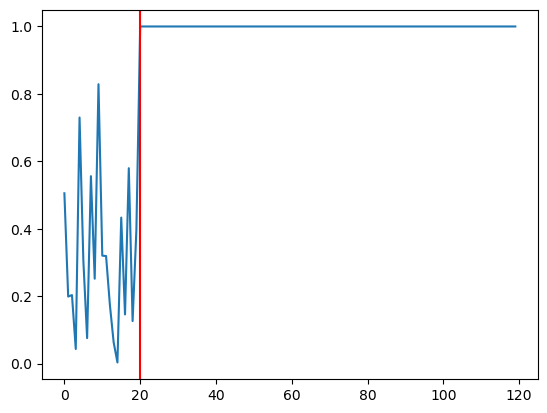

In [441]:
plt.plot(test_array)
plt.axvline(find_stability_point_derivative(test_array,window_size=10, derivative_threshold=0.1, min_stable_duration=10), c='r')

In [624]:
# Initialize the processor
processor = SAM2LongProcessor()
##%%
# Process a video file
first_frame = processor.preprocess_video("/projects/standard/fortson/ribei056/data/Leech/Post 1/170124tb01_post1.mp4",outdir="/projects/standard/fortson/ribei056/software/python/SAM2Long/frames_output_images" )
##%%

Found 126 existing frames, skipping extraction
Using existing frames from: /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/frames_170124tb01_post1
First frame at: /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/frames_170124tb01_post1/00000.jpg


In [625]:
par_list = processor.scan_frames_for_parameters()

pick, pick_frame = processor.find_best_image(par_list)
x = par_list[pick_frame]['centroid_x']
y = par_list[pick_frame]['centroid_y']

In [640]:
# def find_best_image(pars, threshold=None):
pars = par_list
all_peaks = []
peaks0=0
peaks1=0
peaks2=0
peaks3=0
window_size = 10
duration = 10
threshold = 0.1
idx = np.array([idx for idx in pars.keys()])
par_to_check = ['intensity', 'std_x', 'std_y', "width", "length", "centroid_y", "centroid_x", "darkest_center_x", "darkest_center_y"]
for par in par_to_check:
    # Compare with neighbors
    arr = np.array([pars[idx][par] for idx in pars.keys()])
    # peaks0 = find_spikes(arr)
    peaks1 = find_stability_point(arr, window_size=window_size, stability_threshold=threshold, min_stable_duration=duration)
    peaks2 = find_stability_point_derivative(arr, window_size=window_size, derivative_threshold=threshold, min_stable_duration=duration)
    peaks3 = np.argmax(arr)
    print(par, (peaks1+1)*6, (peaks2+1)*6, (peaks3+1)*6)
    all_peaks= np.append(all_peaks, int(peaks2+1))
# print(all_peaks, idx[all_peaks.astype(int)])
pick = int(np.median(np.array(all_peaks)))
pick_frame = idx[pick]

print(pick, pick_frame)

intensity 6 126 84
std_x 186 126 60
std_y 162 126 24
width 186 126 24
length 186 126 24
centroid_y 192 126 300
centroid_x 192 126 78
darkest_center_x 192 126 78
darkest_center_y 192 126 30
21 126


In [641]:
frame = cv2.imread(os.path.join(processor.video_frames_dir, processor.scanned_frames[int(pick)]))

# Convert to grayscale (single channel)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Threshold to isolate dark regions (adjust threshold as needed)
_, thresh = cv2.threshold(gray, 75, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest contour (assuming it's your darkest region)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Calculate the centroid
    M = cv2.moments(largest_contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        darkest_center = (cx, cy)

In [642]:
frame.shape[0] // 2, frame.shape[1] // 2

(425, 424)

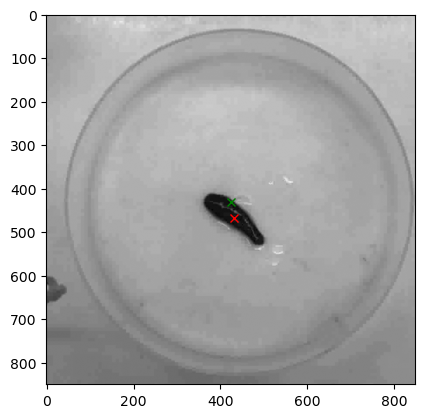

In [643]:
plt.imshow(gray, cmap='grey') 
plt.plot(par_list[pick_frame]['darkest_center_x'],
         par_list[pick_frame]['darkest_center_y'], 'x' , c='r')

plt.plot(x,
         y, 'x' , c='g')



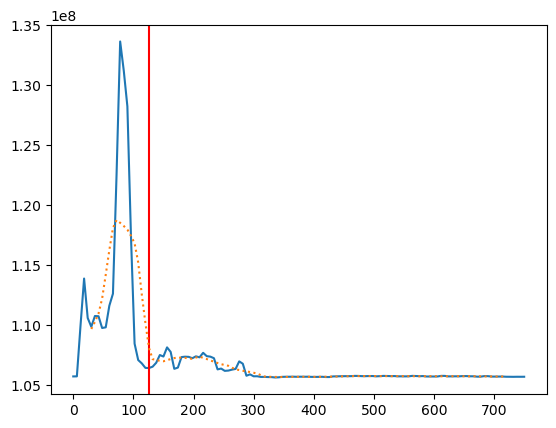

In [644]:
plt.plot([idx for idx,v in par_list.items()],
         [v['intensity'] for idx,v in par_list.items()])
# plt.xlim(0,70)
plt.axvline(pick_frame, c='r')
smoothed = np.convolve([v['intensity'] for idx,v in par_list.items()], np.ones(window_size)/window_size, mode='same')
plt.plot([idx for idx,v in par_list.items()][window_size//2:-window_size//2],
         smoothed[window_size//2:-window_size//2], ls=':')

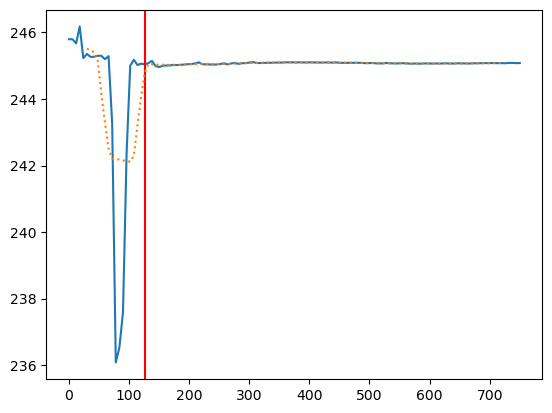

In [645]:
plt.plot([idx for idx,v in par_list.items()],
         [v['width'] for idx,v in par_list.items()])
plt.axvline(pick_frame, c='r')
smoothed = np.convolve([v['width'] for idx,v in par_list.items()], np.ones(window_size)/window_size, mode='same')
plt.plot([idx for idx,v in par_list.items()][window_size//2:-window_size//2],
         smoothed[window_size//2:-window_size//2], ls=':')

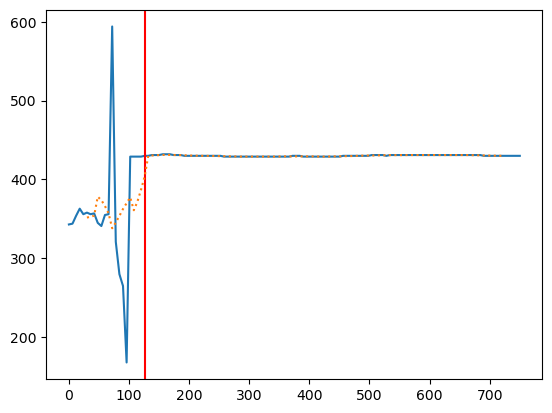

In [646]:
plt.plot([idx for idx,v in par_list.items()], 
         [v['darkest_center_x'] for idx,v in par_list.items()])
plt.axvline(pick_frame, c='r')
smoothed = np.convolve([v['darkest_center_x'] for idx,v in par_list.items()], np.ones(window_size)/window_size, mode='same')
plt.plot([idx for idx,v in par_list.items()][window_size//2:-window_size//2],
         smoothed[window_size//2:-window_size//2], ls=':')

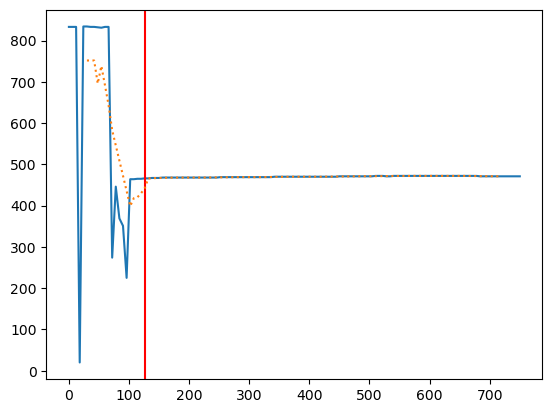

In [647]:
plt.plot([idx for idx,v in par_list.items()], 
         [v['darkest_center_y'] for idx,v in par_list.items()])
plt.axvline(pick_frame, c='r')
smoothed = np.convolve([v['darkest_center_y'] for idx,v in par_list.items()], np.ones(window_size)/window_size, mode='same')
plt.plot([idx for idx,v in par_list.items()][window_size//2:-window_size//2],
         smoothed[window_size//2:-window_size//2], ls=':')

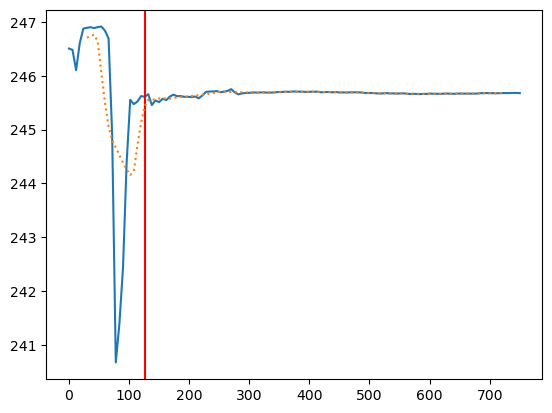

In [648]:
plt.plot([idx for idx,v in par_list.items()], 
         [v['std_x'] for idx,v in par_list.items()])
plt.axvline(pick_frame, c='r')
smoothed = np.convolve([v['std_x'] for idx,v in par_list.items()], np.ones(window_size)/window_size, mode='same')
plt.plot([idx for idx,v in par_list.items()][window_size//2:-window_size//2],
         smoothed[window_size//2:-window_size//2], ls=':')

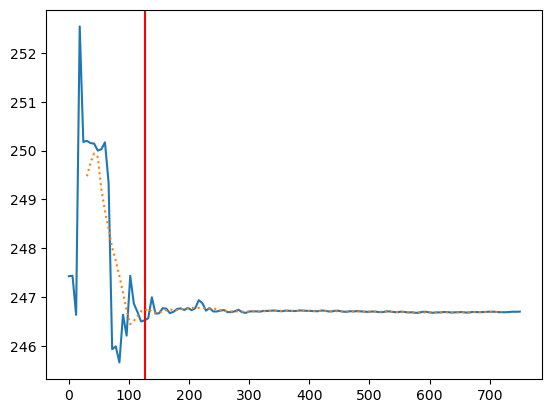

In [649]:
plt.plot([idx for idx,v in par_list.items()],
         [v['std_y'] for idx,v in par_list.items()])
plt.axvline(pick_frame, c='r')
smoothed = np.convolve([v['std_y'] for idx,v in par_list.items()], np.ones(window_size)/window_size, mode='same')
plt.plot([idx for idx,v in par_list.items()][window_size//2:-window_size//2],
         smoothed[window_size//2:-window_size//2], ls=':')

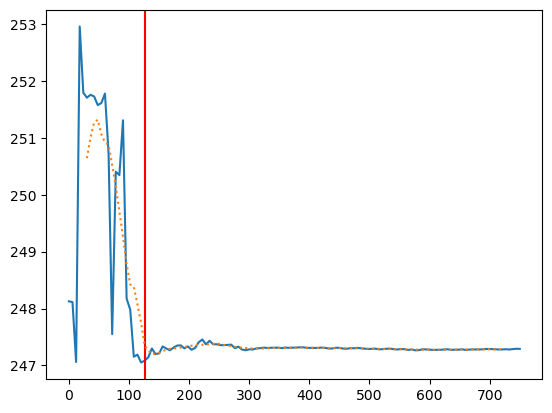

In [650]:
plt.plot([idx for idx,v in par_list.items()],
         [v['length'] for idx,v in par_list.items()])
plt.axvline(pick_frame, c='r')
smoothed = np.convolve([v['length'] for idx,v in par_list.items()], np.ones(window_size)/window_size, mode='same')
plt.plot([idx for idx,v in par_list.items()][window_size//2:-window_size//2],
         smoothed[window_size//2:-window_size//2], ls=':')

(0.0, 850.0)

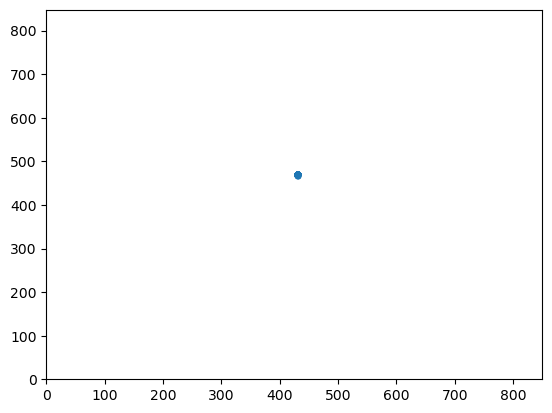

In [651]:
plt.plot([v['darkest_center_x'] for idx,v in par_list.items()][pick:], 
         [v['darkest_center_y'] for idx,v in par_list.items()][pick:], '.', ls="-")
plt.ylim(0,848)
plt.xlim(0,850)

(0.0, 850.0)

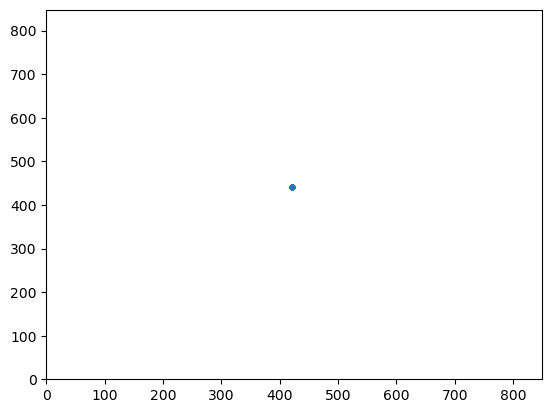

In [652]:
plt.plot([v['centroid_x'] for idx,v in par_list.items()][pick:], 
         [v['centroid_y'] for idx,v in par_list.items()][pick:], '.', ls="-")
plt.ylim(0,848)
plt.xlim(0,850)

In [653]:
par_list

{0: {'centroid_x': np.float64(421.4351820518401),
  'centroid_y': np.float64(441.4306017050769),
  'std_x': np.float64(246.50383876167783),
  'std_y': np.float64(247.42502619367846),
  'width': np.float64(245.7972774974258),
  'length': np.float64(248.12695235713346),
  'angle': np.float64(-146.64603251046836),
  'cov': array([[60764.14252424,  -528.45176679],
         [ -528.45176679, 61219.14358694]]),
  'intensity': 105702914.0,
  'darkest_center_x': 343,
  'darkest_center_y': 833},
 6: {'centroid_x': np.float64(421.5262001360404),
  'centroid_y': np.float64(441.41380650695817),
  'std_x': np.float64(246.478906385724),
  'std_y': np.float64(247.43396430891207),
  'width': np.float64(245.79601674127545),
  'length': np.float64(248.11234580497825),
  'angle': np.float64(-147.17529925399828),
  'cov': array([[60751.8512931 ,  -521.13933136],
         [ -521.13933136, 61223.56669362]]),
  'intensity': 105708287.0,
  'darkest_center_x': 344,
  'darkest_center_y': 833},
 12: {'centroid_x'

In [ ]:
start_frame_idx =3
# Add points to track (include points)
processor.add_point(150, 500,start_frame_idx, "include")  # x, y coordinates
# processor.add_point(250, 300, "include")

# Add exclude points if needed
# processor.add_point(150, 150, "exclude")

# Generate the initial mask (using the tiny model for speed)
mask_output = processor.get_mask(checkpoint="tiny")

# Check the results at intervals
sample_frames = processor.propagate(vis_frame_type="check", checkpoint="tiny")
##%%
# Generate the final output video with masks
video_output = processor.propagate(vis_frame_type="render", checkpoint="tiny")

Found 5 existing frames, skipping extraction
Using existing frames from: /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/frames_sav_000001_copy
First frame at: /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/frames_sav_000001_copy/00000.jpg
Added include point at (150, 500) starting at frame 6
Loading checkpoint: tiny, (/users/5/ribei056/software/python/sam2/checkpoints/sam2.1_hiera_tiny.pt, //users/5/ribei056/software/python/SAM2Long/sam2/configs/sam2.1/sam2.1_hiera_t.yaml)
Model loaded successfully


frame loading (JPEG): 100%|██████████| 5/5 [00:00<00:00, 21.51it/s]


Initial mask generated and saved to /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/output_first_frame.jpg
Cleaned up 4 temporary files from /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/frames_output_images
Starting mask propagation across 5 frames...


propagate in video: 100%|██████████| 4/4 [00:42<00:00, 10.56s/it]


Mask propagation completed in 42.37 seconds
Processing mask results...
Rendering 1 frames with masks...
Processing batch 1/1...
Batch completed in 0.00 seconds (0.00 frames/second)
Total processing time: 42.37 seconds
Generated 0 sample frames with masks
Cleaned up 0 temporary files from /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/frames_output_images
Starting mask propagation across 5 frames...


propagate in video: 100%|██████████| 4/4 [00:28<00:00,  7.23s/it]


Mask propagation completed in 28.95 seconds
Processing mask results...
Rendering 5 frames with masks...
Processing batch 1/1...
Batch completed in 0.53 seconds (7.59 frames/second)
Total processing time: 29.47 seconds
Creating output video...
Running command: ffmpeg -framerate 4.0 -i /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/frames_output_images/frame_%d.jpg -c:v mjpeg /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/output_video.mp4
Video creation completed in 0.14 seconds
Generated output video: /home/fortson/ribei056/software/python/SAM2Long/frames_output_images/output_video.mp4


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 11.2.0 (Anaconda gcc)
  configuration: --prefix=/users/5/ribei056/.conda/envs/samlong --cc=/croot/ffmpeg_1743153284778/_build_env/bin/x86_64-conda-linux-gnu-cc --ar=/croot/ffmpeg_1743153284778/_build_env/bin/x86_64-conda-linux-gnu-ar --nm=/croot/ffmpeg_1743153284778/_build_env/bin/x86_64-conda-linux-gnu-nm --ranlib=/croot/ffmpeg_1743153284778/_build_env/bin/x86_64-conda-linux-gnu-ranlib --strip=/croot/ffmpeg_1743153284778/_build_env/bin/x86_64-conda-linux-gnu-strip --disable-doc --enable-swresample --enable-swscale --enable-openssl --enable-libxml2 --enable-libtheora --enable-demuxer=dash --enable-postproc --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libdav1d --enable-zlib --enable-libaom --enable-pic --enable-shared --disable-static --disable-gpl --enable-version3 --disable-sdl2 --enable-libopenh264 --enable-libopus --enable-libmp3lame --enable-lib